Tucson               435945.966478
Albuquerque          449905.549470
San Francisco        393749.297943
Berlin               243230.744245
Deisenhofen          248660.227680
Labastide-Marnhac    309701.903950
Aruba                418597.173700
dtype: float64


Text(0, 0.5, 'Yearly energy yield (W hr)')

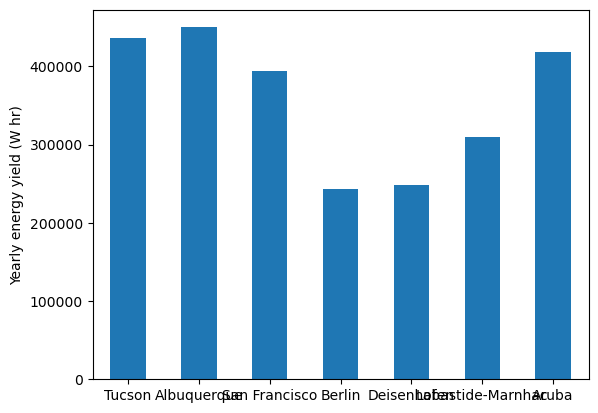

In [3]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

coordinates = [
    (32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),
    (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),
    (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
    (48.01820,11.5941, 'Deisenhofen', 600, 'Etc/GMT-1'),
    (44.3844227, 1.3452881, 'Labastide-Marnhac', 200, 'Etc/GMT-1'),
    (12.5430032, -70.0398934, 'Aruba', 0, 'Etc/GMT+6')
    
]

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,
                                          map_variables=True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)
    
system = {'module': module, 'inverter': inverter,
          'surface_azimuth': 180}


energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )
    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy


energies = pd.Series(energies)


print(energies)


energies.plot(kind='bar', rot=0)


plt.ylabel('Yearly energy yield (W hr)')

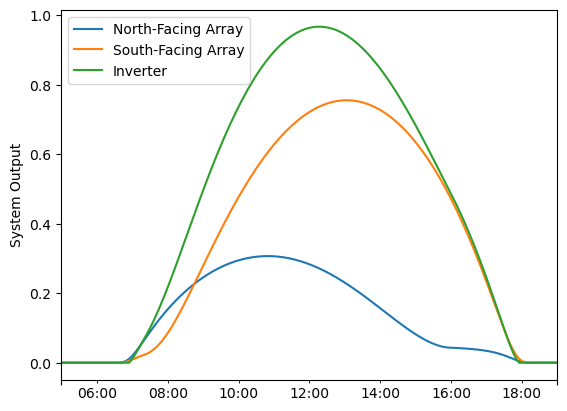

In [4]:
from pvlib import pvsystem, modelchain, location
import pandas as pd
import matplotlib.pyplot as plt

array_kwargs = dict(
    module_parameters=dict(pdc0=1, gamma_pdc=-0.004),
    temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
)

arrays = [
    pvsystem.Array(pvsystem.FixedMount(24, 30), name='North-Facing Array',
                   **array_kwargs),
    pvsystem.Array(pvsystem.FixedMount(24, 210), name='South-Facing Array',
                   **array_kwargs),
]
loc = location.Location(48.01820,11.5941)
system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3))
mc = modelchain.ModelChain(system, loc, aoi_model='physical',
                           spectral_model='no_loss')

times = pd.date_range('2023-03-12 05:00', '2023-03-12 19:00', freq='5min',
                      tz='Etc/GMT-1')


weather = loc.get_clearsky(times)
mc.run_model(weather)

fig, ax = plt.subplots()
for array, pdc in zip(system.arrays, mc.results.dc):
    pdc.plot(label=f'{array.name}')
mc.results.ac.plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()

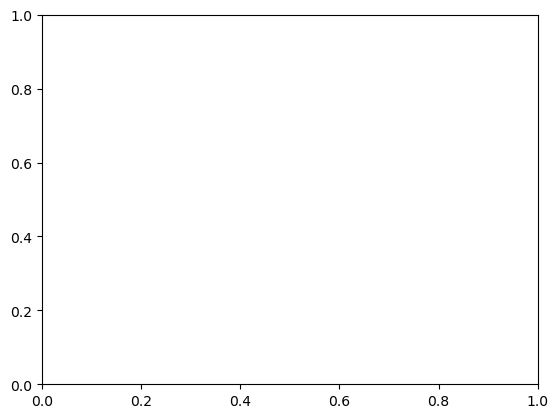

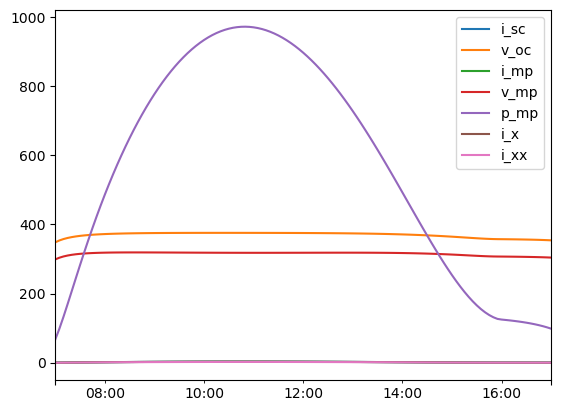

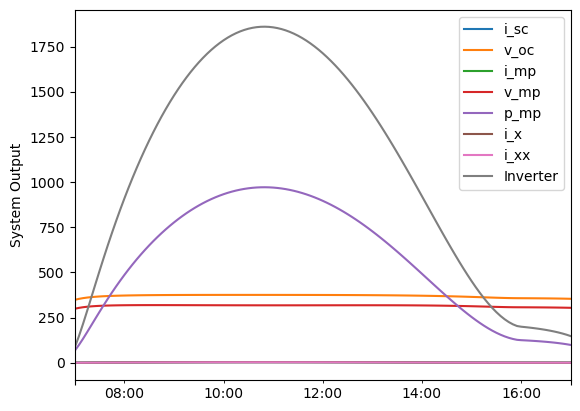

In [73]:
from pvlib import pvsystem, modelchain, location
import pandas as pd
import matplotlib.pyplot as plt

modules = pvsystem.retrieve_sam('cecmod')
module_parameters = modules['WINAICO_WSP_315M6']


inverters = pvsystem.retrieve_sam('cecinverter')

## Fronius Primo 7.6-1 208-240
inverter_parameters = inverters['Fronius_USA__Fronius_Primo_7_6_1_208_240__240V_']

temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)

system_one_array = pvsystem.PVSystem(module_parameters=module_parameters,
                                     temperature_model_parameters=temperature_model_parameters,
                                     inverter_parameters=inverter_parameters)

array1 = pvsystem.Array(pvsystem.FixedMount(24, 30), name='South-Facing Array', 
                     albedo=None, surface_type=None, module=None, module_type=None, 
                     module_parameters=module_parameters, 
                     temperature_model_parameters=temperature_model_parameters, 
                     modules_per_string=10, strings=1, array_losses_parameters=None)
array2 = pvsystem.Array(pvsystem.FixedMount(24, 300), name='North-Facing Array', 
                     albedo=None, surface_type=None, module=None, module_type=None, 
                     module_parameters=module_parameters, 
                     temperature_model_parameters=temperature_model_parameters, 
                     modules_per_string=10, strings=1, array_losses_parameters=None)

system_two_arrays = pvsystem.PVSystem(arrays=[array1, array1],
                                      inverter_parameters=inverter_parameters)

loc = location.Location(48.01820, 11.5941)
mc = modelchain.ModelChain(system_two_arrays, loc, 
                           aoi_model='physical',
                           spectral_model='no_loss')

times = pd.date_range('2023-03-13 07:00', '2023-03-13 17:00', freq='5min', tz='Etc/GMT-1')


weather = pd.DataFrame([[1050, 1000, 100, 30, 5]],
                       columns=['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed'])


weather = loc.get_clearsky(times)
## Run the model
mc.run_model(weather)

fig, ax = plt.subplots()
for array, pdc in zip([array1, array2], mc.results.dc):
    pdc.plot(label=f'{array.name}')
mc.results.ac.plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()

In [5]:
mc.results.dc


(2023-03-12 05:00:00+01:00    0.0
 2023-03-12 05:05:00+01:00    0.0
 2023-03-12 05:10:00+01:00    0.0
 2023-03-12 05:15:00+01:00    0.0
 2023-03-12 05:20:00+01:00    0.0
                             ... 
 2023-03-12 18:40:00+01:00    0.0
 2023-03-12 18:45:00+01:00    0.0
 2023-03-12 18:50:00+01:00    0.0
 2023-03-12 18:55:00+01:00    0.0
 2023-03-12 19:00:00+01:00    0.0
 Freq: 5T, Name: p_mp, Length: 169, dtype: float64,
 2023-03-12 05:00:00+01:00    0.0
 2023-03-12 05:05:00+01:00    0.0
 2023-03-12 05:10:00+01:00    0.0
 2023-03-12 05:15:00+01:00    0.0
 2023-03-12 05:20:00+01:00    0.0
                             ... 
 2023-03-12 18:40:00+01:00    0.0
 2023-03-12 18:45:00+01:00    0.0
 2023-03-12 18:50:00+01:00    0.0
 2023-03-12 18:55:00+01:00    0.0
 2023-03-12 19:00:00+01:00    0.0
 Freq: 5T, Name: p_mp, Length: 169, dtype: float64)

In [35]:
dict(filter(lambda item: "Fro" in item[0], inverters.items()))

{'Fronius_International_GmbH__Fronius_Primo_10_0_1_208_240__208V_': Vac                   208
 Pso             36.211998
 Paco               9995.0
 Pdco         10292.209961
 Vdco                660.0
 C0                   -0.0
 C1              -0.000029
 C2              -0.000759
 C3              -0.002785
 Pnt                2.9985
 Vdcmax              800.0
 Idcmax          15.594258
 Mppt_low            100.0
 Mppt_high           800.0
 CEC_Date         3/1/2019
 CEC_Type     Grid Support
 Name: Fronius_International_GmbH__Fronius_Primo_10_0_1_208_240__208V_, dtype: object,
 'Fronius_International_GmbH__Fronius_Primo_10_0_1_208_240__240V_': Vac                   240
 Pso             44.270973
 Paco               9995.0
 Pdco         10295.990234
 Vdco                655.0
 C0              -0.000001
 C1              -0.000028
 C2              -0.000619
 C3               0.000286
 Pnt                2.9985
 Vdcmax              800.0
 Idcmax          15.719069
 Mppt_low            10

Object `Location` not found.
